# side model feature selection

In [1]:
import numpy as np
import pandas as pd

df_features = pd.read_parquet("data/features_3m.parquet")
df_label = pd.read_parquet("data/label_3m_side.parquet")
assert df_features.shape[0] == df_label.shape[0]
print(df_label.shape)
df_label.head()

(818400, 8)


,open,high,low,close,volume,ret,trgt,bin
2020-06-01 00:00:00+00:00,9446.49,9447.64,9428.40,9439.99,1045.443,NaN,NaN,0.0
2020-06-01 00:03:00+00:00,9439.99,9448.97,9420.85,9436.93,801.558,NaN,NaN,0.0
2020-06-01 00:06:00+00:00,9436.94,9471.42,9436.45,9465.00,1171.385,NaN,NaN,0.0
2020-06-01 00:09:00+00:00,9465.43,9488.85,9463.46,9475.51,984.391,NaN,NaN,0.0
2020-06-01 00:12:00+00:00,9475.51,9490.00,9472.90,9481.59,736.379,NaN,NaN,0.0


In [2]:
side_features = df_features.iloc[240:]
side_label = df_label.iloc[240:]


mask = (side_label["bin"].astype(int) != 0).tolist()
side_features = side_features[mask]
side_label = side_label[mask]["bin"].astype(int)

print(side_features.shape)
print(side_label.shape)

side_features.isna().sum(axis=0).sort_values(ascending=False)

(12839, 1684)
(12839,)


1h_swamicharts_stochastic_43     5
1h_acp_pwr_17                    5
1h_acp_pwr_15                    5
1h_acp_pwr_14                    5
1h_acp_pwr_13                    5
                                ..
3m_comb_spectrum_dom_cycle_dt    0
3m_comb_spectrum_dom_cycle       0
3m_highpass_bp_lag3              0
3m_highpass_bp_lag2              0
15m_ac_0                         0
Length: 1684, dtype: int64

In [15]:
# meta feature selection
from feature_engine.selection import MRMR

sel = MRMR(
    method="FCQ",
    max_features=side_features.shape[1] // 2,
    scoring="f1",
    cv=5,
    regression=False,
    n_jobs=-1,
)
sel.fit(side_features, side_label)

MRMR(cv=5, max_features=631, method='FCQ', n_jobs=-1, scoring='f1')

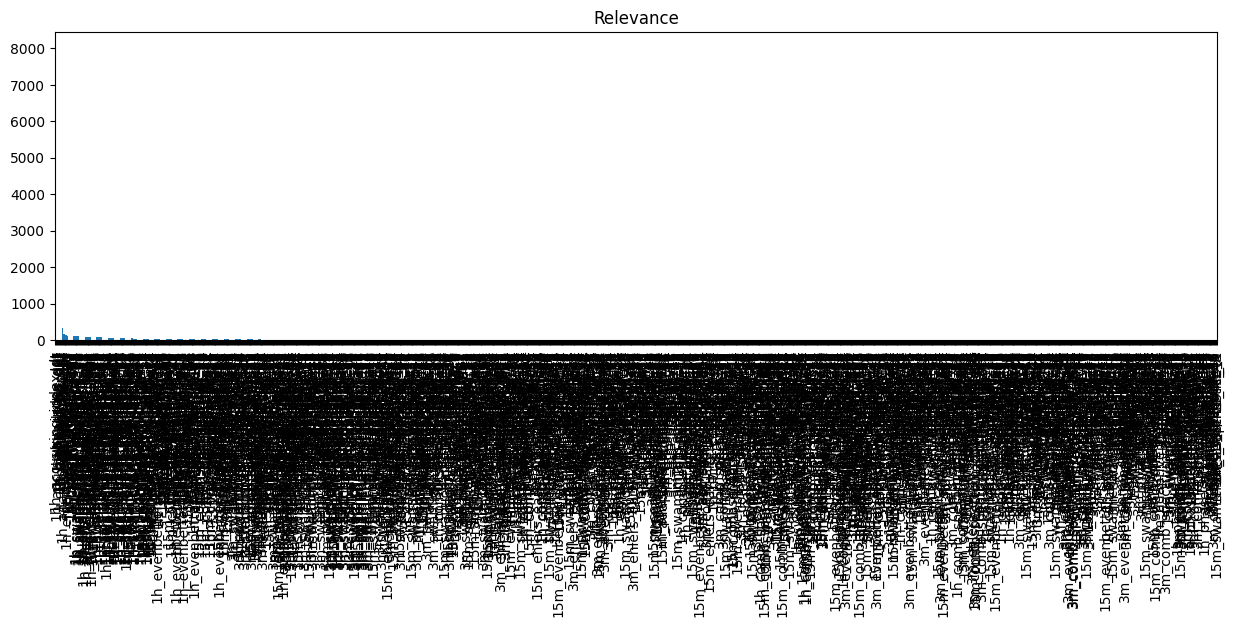

In [16]:
import matplotlib.pyplot as plt

pd.Series(sel.relevance_, index=sel.variables_).sort_values(ascending=False).plot.bar(
    figsize=(15, 4)
)
plt.title("Relevance")
plt.show()

In [17]:
side_res = pd.Series(sel.relevance_, index=sel.variables_).sort_values(ascending=False)
side_res

1h_acc_swing_index_dt            8042.691544
1h_acc_swing_index_ddt           4180.631182
1h_bandpass_ddt                  2574.572604
1h_highpass_bp_ddt               2523.976063
1h_roofing_filter_ddt             729.671320
                                    ...     
1h_phase_accumulation               0.000029
3m_comb_spectrum_pwr_38             0.000018
3m_dft_spectrum_3                   0.000016
15m_swamicharts_stochastic_43       0.000010
3m_adaptive_rsi_dt                  0.000002
Length: 1263, dtype: float64

In [18]:
import json

with open("data/mrmr_side_features.json", "w") as f:
    json.dump(side_res.to_dict(), f)

In [19]:
from pathlib import Path

feature_info = {
    "all": [],
    "side": {"3m": [], "15m": [], "1h": []},
    "meta": {"3m": [], "15m": [], "1h": [], "model_res": []},
}

for k, v in side_res.to_dict().items():
    if v > 1:
        if k.startswith("3m_"):
            feature_info["side"]["3m"].append(k)
            feature_info["all"].append(k.replace("3m_", ""))
        elif k.startswith("15m_"):
            feature_info["side"]["15m"].append(k)
            feature_info["all"].append(k.replace("15m_", ""))
        elif k.startswith("1h_"):
            feature_info["side"]["1h"].append(k)
            feature_info["all"].append(k.replace("1h_", ""))

feature_info["all"] = sorted(list(set(feature_info["all"])))
feature_info["side"]["3m"] = sorted(list(set(feature_info["side"]["3m"])))
feature_info["side"]["15m"] = sorted(list(set(feature_info["side"]["15m"])))
feature_info["side"]["1h"] = sorted(list(set(feature_info["side"]["1h"])))

feature_info["meta"]["3m"] = sorted(list(set(feature_info["meta"]["3m"])))
feature_info["meta"]["15m"] = sorted(list(set(feature_info["meta"]["15m"])))
feature_info["meta"]["1h"] = sorted(list(set(feature_info["meta"]["1h"])))
feature_info["meta"]["model_res"] = sorted(list(set(feature_info["meta"]["model_res"])))

with open("custom_indicators/feature_info.json", "w") as f:
    json.dump(feature_info, f)

# meta model feature selection

In [4]:
import lightgbm as lgb
import numpy as np
import pandas as pd

from custom_indicators.selection import SIDE_ALL

df_features = pd.read_parquet("data/features_15m.parquet")
df_label = pd.read_parquet("data/label_15m_meta.parquet")

model_side = lgb.Booster(model_file="custom_indicators/models/model_side.txt")
model_side_res = model_side.predict(df_features[SIDE_ALL])
df_features["model_side_res"] = model_side_res
print(df_features.shape)

assert df_features.shape[0] == df_label.shape[0]
print(df_label.shape)
df_label.head()

(163680, 1264)
(163680, 9)


,open,high,low,close,volume,ret,trgt,bin,side
2020-06-01 00:00:00+00:00,9446.49,9490.00,9420.85,9481.59,4739.156,NaN,NaN,0.0,0.0
2020-06-01 00:15:00+00:00,9481.04,9497.51,9474.04,9484.62,2339.632,NaN,NaN,0.0,0.0
2020-06-01 00:30:00+00:00,9484.62,9489.99,9460.00,9465.32,1352.402,NaN,NaN,0.0,0.0
2020-06-01 00:45:00+00:00,9465.32,9505.00,9463.94,9496.22,2166.591,NaN,NaN,0.0,0.0
2020-06-01 01:00:00+00:00,9496.20,9503.00,9472.00,9474.04,1738.375,NaN,NaN,0.0,0.0


In [5]:
meta_features = df_features.iloc[240:]
meta_label = df_label.iloc[240:]

# mask = meta_label["ret"].notna()
mask = [True] * meta_label.shape[0]

meta_features = meta_features[mask]
meta_label = meta_label[mask]["bin"].astype(int)

print(meta_features.shape)
print(meta_label.shape)

(163440, 1264)
(163440,)


In [6]:
# meta feature selection
from feature_engine.selection import MRMR

sel = MRMR(
    method="FCQ",
    max_features=meta_features.shape[1] // 2,
    scoring="f1",
    cv=5,
    regression=False,
    n_jobs=-1,
)
sel.fit(meta_features, meta_label)

MRMR(cv=5, max_features=632, method='FCQ', n_jobs=-1, scoring='f1')

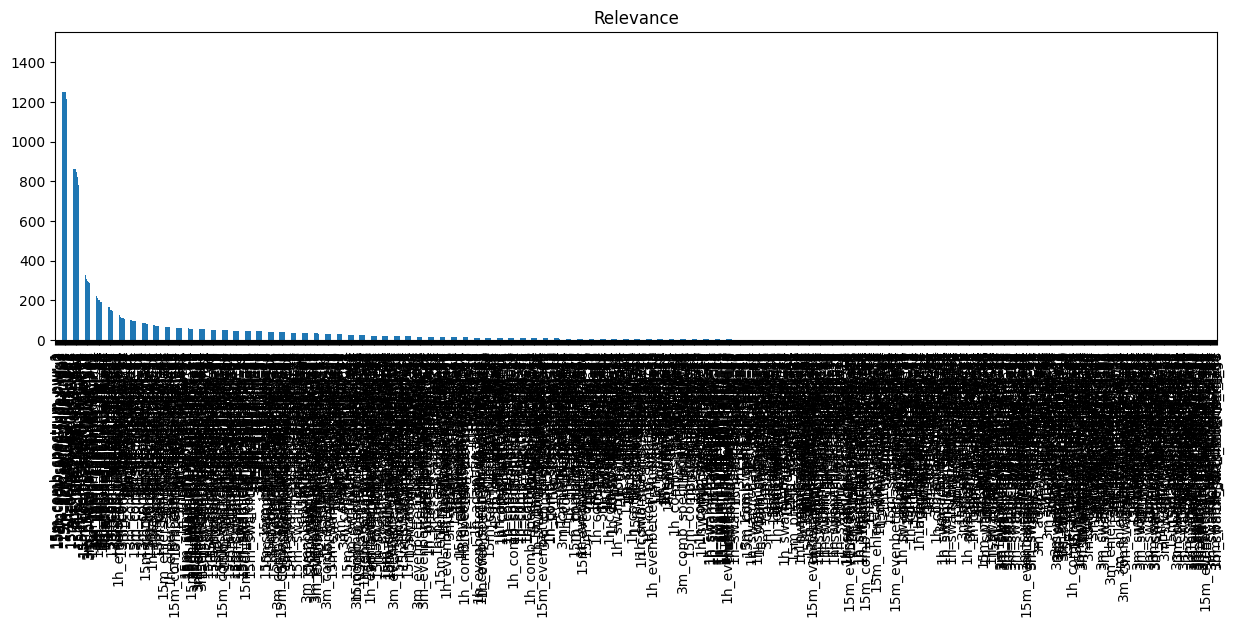

In [7]:
import matplotlib.pyplot as plt

pd.Series(sel.relevance_, index=sel.variables_).sort_values(ascending=False).plot.bar(
    figsize=(15, 4)
)
plt.title("Relevance")
plt.show()

In [9]:
meta_res = pd.Series(sel.relevance_, index=sel.variables_).sort_values(ascending=False)
meta_res

15m_comb_spectrum_pwr_1         1477.827636
15m_comb_spectrum_pwr_2         1467.995688
15m_comb_spectrum_pwr_0         1399.076003
15m_comb_spectrum_pwr_3         1334.272742
3m_acc_swing_index_lag2         1287.009976
                                   ...     
15m_ac_45                          0.000185
1h_dft_dom_cycle_ddt               0.000098
15m_phase_accumulation_lag1        0.000078
1h_swamicharts_rsi_37              0.000052
3m_swamicharts_stochastic_18       0.000008
Length: 1264, dtype: float64

In [10]:
import json

with open("data/mrmr_meta_features.json", "w") as f:
    json.dump(meta_res.to_dict(), f)

In [11]:
meta_res.to_dict()["model_side_res"]

8.287330968686994

In [12]:
len([k for k, v in meta_res.to_dict().items() if v > 1])

906

In [14]:
from pathlib import Path

feature_info = Path("custom_indicators/feature_info.json")
if feature_info.exists():
    with open(feature_info, "r") as f:
        feature_info = json.load(f)

for k, v in meta_res.to_dict().items():
    if v > 1:
        if k.startswith("3m_"):
            feature_info["meta"]["3m"].append(k)
            feature_info["all"].append(k.replace("3m_", ""))
        elif k.startswith("15m_"):
            feature_info["meta"]["15m"].append(k)
            feature_info["all"].append(k.replace("15m_", ""))
        elif k.startswith("1h_"):
            feature_info["meta"]["1h"].append(k)
            feature_info["all"].append(k.replace("1h_", ""))
        else:
            feature_info["meta"]["model_res"].append(k)

feature_info["all"] = sorted(list(set(feature_info["all"])))
feature_info["side"]["3m"] = sorted(list(set(feature_info["side"]["3m"])))
feature_info["side"]["15m"] = sorted(list(set(feature_info["side"]["15m"])))
feature_info["side"]["1h"] = sorted(list(set(feature_info["side"]["1h"])))

feature_info["meta"]["3m"] = sorted(list(set(feature_info["meta"]["3m"])))
feature_info["meta"]["15m"] = sorted(list(set(feature_info["meta"]["15m"])))
feature_info["meta"]["1h"] = sorted(list(set(feature_info["meta"]["1h"])))
feature_info["meta"]["model_res"] = sorted(list(set(feature_info["meta"]["model_res"])))

with open("custom_indicators/feature_info.json", "w") as f:
    json.dump(feature_info, f)